# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 06 : pipeline de modélisation et premières expérimentations
---

### Identité du document
* **Statut :** Phase 1 (exploration & prototypage)
* **Dernière mise à jour :** 10/01/2026
* **Dépendances notebooks**: Notebooks 0 à 7,feature engineering

### Description
Ce notebook constitue la première étape de la construction des modèles prédictifs. Il s’appuie sur les données nettoyées et enrichies afin de tester plusieurs approches de modélisation, comparer leurs performances et établir une base de référence. L’objectif est de documenter un pipeline reproductible et d’identifier les modèles les plus prometteurs.


### Objectifs principaux
1. Charger le dataset préparé depuis `processed/`.  
2. Mettre en place le split train/test.  
3. Entraîner les modèles baseline :  
   - Régression linéaire.  
   - Régression Ridge/Lasso.  
   - Random Forest.  
4. Évaluer les performances avec RMSE, MAE, R².  
5. Intégrer MLflow pour tracer les runs (paramètres, métriques, artefacts).  
6. Documenter les résultats et générer un rapport synthétique.

---
### Dépendances critiques
* `src.feature_engineering` : pipeline de features.  
* `src.utils` : fonctions de split et métriques.  
* `sklearn` : librairie de modélisation.  
* `mlflow` : suivi des expériences.

### LIVRABLES
1. Modèles baseline entraînés et sauvegardés (`models/`).  
2. Résultats des métriques dans MLflow UI.  
3. Tableaux comparatifs des performances (`reports/model_baseline.md`).  
4. Visualisations des résidus et des distributions d’erreurs.  
5. Notebook documenté et reproductible via des scripts

---

# 📚 Table des matières

- [Section 0 : Importation des packages](#section-0)  
- [Section 1 : Chargement des données feature engineering](#section-1)  
- [Section 2 : Préprocessing et split train/test](#section-2)  
- [Section 3 : Entraînement des modèles basiques](#section-3)  
- [Section 4 : Évaluation des performances](#section-4)  
- [Section 5 : Intégration MLflow](#section-5)  
- [Section 6 : Documentation et synthèse](#section-6)  

> Note : la table des matières est indicative. Utilisez la navigation intégrée de votre éditeur (ex. outline VSCode) pour accéder rapidement aux sections.
---

<a id="section-0"></a>
# Section 0 : Importation des packages

In [1]:
import logging
import pandas as pd
from pathlib import Path
import logging
import numpy as np


# Import des fonctions utilitaires 

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))


from data.load_data import load_data_raw
from utils.config_loader import load_config, create_directories
from utils.eda_logger import setup_eda_logger

import seaborn as sns
import matplotlib.pyplot as plt

#pipeline data
from utils.config_loader import load_config
from data.load_data import load_data_raw
from data.clean_data import run_cleaning_pipeline
from feature_engineering.build_features import run_feature_engineering_pipeline
import copy

# pipeline modele
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score









In [2]:
# Configuration du logger pour voir les infos dans le notebook
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
logger = logging.getLogger("notebook")

<a id="section-1"></a>
# Section 1:Chargement des data

In [3]:
cfg = load_config()
create_directories(cfg)

cfg_ml = copy.deepcopy(cfg)
# désactiver l'imputation dans la copie ml (non persistée)
cfg_ml.cleaning.section_1.enable_imputation = False

# Chargement raw
logger.info("--- 1. LOADING ---")
df_raw = load_data_raw(cfg)



2026-01-12 22:18:43,599 - Configuration 'config' chargée (project_root=C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2)
2026-01-12 22:18:43,604 - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\raw
2026-01-12 22:18:43,606 - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\interim
2026-01-12 22:18:43,608 - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\processed
2026-01-12 22:18:43,610 - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\figures
2026-01-12 22:18:43,614 - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\reports
2026-01-12 22:18:43,627 - --- 1. LOADING ---
2026-01-12 22:18:43,663 - DataFrame chargé : 3376 lignes, 46 colonnes
2026-0

In [4]:

# CLEANING sans imputation
logger.info(" CLEANING sans imputation")
df_cleaned = run_cleaning_pipeline(df_raw, cfg_ml)  #imputation False

2026-01-12 22:18:43,705 -  CLEANING sans imputation
2026-01-12 22:18:43,707 - --- Exécution : section_0 ---
2026-01-12 22:18:43,890 - --- Exécution : section_2 ---
2026-01-12 22:18:43,972 - --- Exécution : section_3 ---


   [Audit] section_0 : -1752 lignes exportées vers section_0_removed.csv
   [Audit] section_2 : -36 lignes exportées vers section_2_removed.csv


2026-01-12 22:18:44,431 - --- Exécution : section_1 ---
2026-01-12 22:18:44,514 - ✓ Données sauvegardées dans : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\interim\data_cleaned.csv


   [Audit] section_3 : -59 lignes exportées vers section_3_removed.csv
   [Audit] section_1 : -108 lignes exportées vers section_1_removed.csv


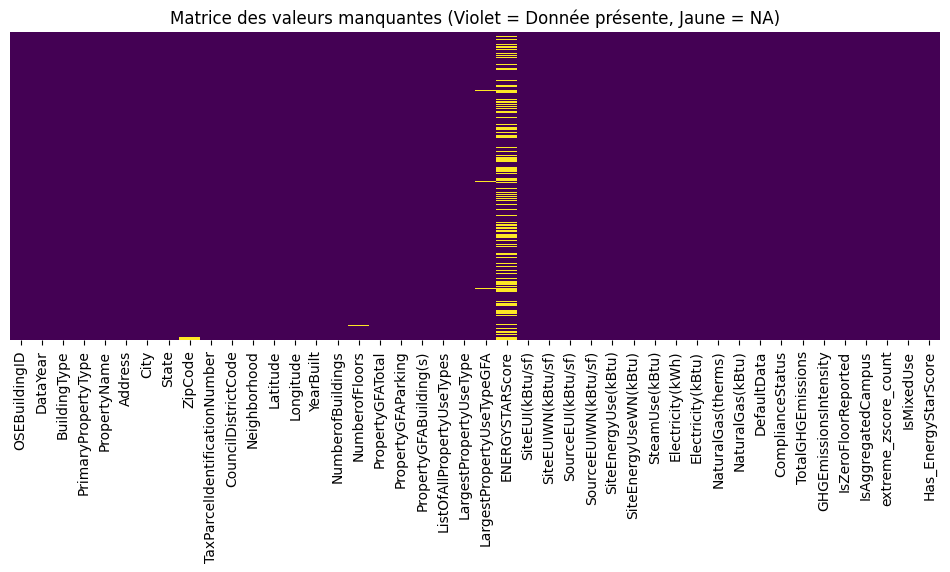

In [5]:
plt.figure(figsize=(12, 4))
sns.heatmap(df_cleaned.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Matrice des valeurs manquantes (Violet = Donnée présente, Jaune = NA)")
plt.show()

# Section 2 : Split train-test

In [6]:
df_cleaned["PrimaryPropertyType"].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'K-12 School', 'Large Office', 'Medical Office', 'Retail Store',
       'Hospital', 'Warehouse', 'Distribution Center', 'Worship Facility',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant'], dtype=object)

In [7]:
# Détection rapide des valeurs manquantes
TARGET = "TotalGHGEmissions"

print("NaN dans Target:", df_cleaned[TARGET].isna().sum())
print("Pourcentage:", df_cleaned[TARGET].isna().mean() * 100)

# NaN par type de bâtiment
print("\nNaN par PrimaryPropertyType:")
print(df_cleaned.groupby('PrimaryPropertyType')[TARGET].apply(lambda x: x.isna().sum()))

NaN dans Target: 0
Pourcentage: 0.0

NaN par PrimaryPropertyType:
PrimaryPropertyType
Distribution Center            0
Hospital                       0
Hotel                          0
K-12 School                    0
Laboratory                     0
Large Office                   0
Medical Office                 0
Mixed Use Property             0
Other                          0
Refrigerated Warehouse         0
Restaurant                     0
Retail Store                   0
Self-Storage Facility          0
Small- and Mid-Sized Office    0
Supermarket / Grocery Store    0
University                     0
Warehouse                      0
Worship Facility               0
Name: TotalGHGEmissions, dtype: int64


## Split avant feature engineering et log transformation de target

In [8]:
TARGET = "TotalGHGEmissions"
X = df_cleaned.drop(columns=[TARGET])
y = np.log1p(df_cleaned[TARGET])

# Le split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df_cleaned['PrimaryPropertyType']
)


## Feature Engineering 

>Note :En soit le Double Feature Engineering est une erreur :si run_feature_engineering_pipeline calcule des moyennes ou des medianes sur le teste alors cela créer du leakage: le test est transformé avec ses propres statistiques au lieu de celles du train .Dans notre cas tel n'est pas le cas.Auncun probléme n'interviens et au vue du code cela revient au même que de regrouper les deux .Pour des contraintes de temps nous conservons notre demarche

In [9]:

# En cas d'éventuel calcul groupé lors du feature enginenning

logger.info(" Feature Engineering sur TRAIN ")
X_train.name = "X_train"
X_test.name = "X_test"
# Ces transformations doivent être conçues pour n'utiliser que les données de X_train en cas d'utilisation de stats globale
df_train_fe = run_feature_engineering_pipeline(X_train, cfg_ml)
y_train = y_train.loc[df_train_fe.index]  # Réaligner les cibles 

logger.info(" Feature Engineering sur TEST ")
# Appliquez les MÊMES transformations au test, sans ré-apprendre de paramètres.
df_test_fe = run_feature_engineering_pipeline(X_test, cfg_ml)
y_test = y_test.loc[df_test_fe.index]

#  Préparation  pour le pipeline ML
X_train_clean = df_train_fe.copy()
X_test_clean = df_test_fe.copy()


2026-01-12 22:18:45,024 -  Feature Engineering sur TRAIN 
2026-01-12 22:18:45,027 - --- Démarrage : Feature Engineering ---
2026-01-12 22:18:45,082 - ✓ Feature Engineering terminé. Shape: (1136, 20)
2026-01-12 22:18:45,084 -  Feature Engineering sur TEST 
2026-01-12 22:18:45,085 - --- Démarrage : Feature Engineering ---
2026-01-12 22:18:45,114 - ✓ Feature Engineering terminé. Shape: (285, 20)


✓ Feature engineering sauvegardé dans : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\processed\X_train.csv
✓ Feature engineering sauvegardé dans : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\processed\X_test.csv


In [10]:
X_train_clean.columns

Index(['NumberofFloors', 'NumberofBuildings', 'Age', 'ENERGYSTARScore',
       'PrimaryPropertyType', 'BuildingType', 'Neighborhood', 'Latitude',
       'Longitude', 'Is_Downtown', 'distance_to_center_proxy', 'log_GFA',
       'surface_per_building', 'surface_per_floor', 'Has_Parking',
       'Parking_share', 'Has_ENERGYSTAR', 'Has_Gas', 'Has_Steam',
       'Age_ENERGYSTAR'],
      dtype='object')

In [11]:
X_train_clean.shape

(1136, 20)

In [12]:
X_test.shape

(285, 43)

In [13]:
y_train.head()

1191    3.923556
1968    3.379974
980     4.879615
119     7.628916
2087    2.989211
Name: TotalGHGEmissions, dtype: float64

# Section 3 : Modéle baseline

In [14]:
print(X_train_clean.columns.tolist())

['NumberofFloors', 'NumberofBuildings', 'Age', 'ENERGYSTARScore', 'PrimaryPropertyType', 'BuildingType', 'Neighborhood', 'Latitude', 'Longitude', 'Is_Downtown', 'distance_to_center_proxy', 'log_GFA', 'surface_per_building', 'surface_per_floor', 'Has_Parking', 'Parking_share', 'Has_ENERGYSTAR', 'Has_Gas', 'Has_Steam', 'Age_ENERGYSTAR']


## Custom Transformers

In [15]:

# clé de regroupement
GROUP_COL = "PrimaryPropertyType"


# Exclure PrimaryPropertyType des colonnes catégorielles à imputer

cat_cols = X_train_clean.select_dtypes(include="object").columns.tolist()

# colonnes catégorielles À IMPUTER (sans la clé de groupe)
categorical_features = [c for c in cat_cols if c != GROUP_COL]


In [16]:


num_cols = X_train_clean.select_dtypes(include="number").columns.tolist()
cat_cols = X_train_clean.select_dtypes(include="object").columns.tolist()

class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col: str, min_group_size: int = 1):
        self.group_col = group_col
        self.min_group_size = min_group_size
        self.integer_cols_ = [] # Pour stocker les colonnes qui doivent être arrondies

    def fit(self, X: pd.DataFrame, y=None):
        if self.group_col not in X.columns:
            raise ValueError(f"{self.group_col} absent dans X lors de fit()")
        
        # Identifier les colonnes numériques
        numeric_cols = X.select_dtypes(include="number").columns
        
        # Détecter les colonnes "purement entières" (ex: 1.0, 2.0, NaN)
        self.integer_cols_ = []
        for col in numeric_cols:
            non_na_values = X[col].dropna()
            if not non_na_values.empty and (non_na_values % 1 == 0).all():
                self.integer_cols_.append(col)

        # Compter et calculer médianes par groupe
        group_counts = X.groupby(self.group_col).size()
        medians = X.groupby(self.group_col).median(numeric_only=True)

        for g, cnt in group_counts.items():
            if cnt < self.min_group_size and g in medians.index:
                medians.loc[g, :] = np.nan
        
        self.group_medians_ = medians
        self.global_median_ = X.median(numeric_only=True)
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        for col in self.group_medians_.columns:
            if col not in X.columns:
                continue
            
            # Imputation par groupe puis globale
            X[col] = X[col].fillna(X[self.group_col].map(self.group_medians_[col]))
            X[col] = X[col].fillna(self.global_median_[col])
            
            # Si la colonne était initialement composée d'entiers, on arrondit au supérieur
            if col in self.integer_cols_:
                X[col] = np.ceil(X[col]).astype(int)
                
        return X.drop(columns=[self.group_col], errors="ignore")

class GroupModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col: str, categorical_cols=None, min_group_size: int = 1):
        # ne pas transformer categorical_cols ici 
        self.group_col = group_col
        self.categorical_cols = categorical_cols  # peut être None ; on infère dans fit()
        self.min_group_size = min_group_size

    def fit(self, X: pd.DataFrame, y=None):
        if self.group_col not in X.columns:
            raise ValueError(f"{self.group_col} absent dans X lors de fit()")
        # si categorical_cols n'est pas fourni, inférer toutes les colonnes sans 'group_col' de type object/category
        if self.categorical_cols is None:
            inferred = X.select_dtypes(include=["object", "category"]).columns.tolist()
            self.categorical_cols = [c for c in inferred if c != self.group_col]
        # calculer mode par groupe
        group_counts = X.groupby(self.group_col).size()
        self.group_modes_ = {}
        for col in self.categorical_cols:
            modes = X.groupby(self.group_col)[col].agg(
                lambda s: s.mode().iloc[0] if not s.mode().empty else None
            )
            for g, cnt in group_counts.items():
                if cnt < self.min_group_size and g in modes.index:
                    modes.loc[g] = None
            self.group_modes_[col] = modes
        # global modes fallback
        self.global_modes_ = {col: X[col].mode().iloc[0] for col in self.categorical_cols}
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        for col in self.categorical_cols:
            if col not in X.columns:
                continue
            X[col] = X[col].fillna(X[self.group_col].map(self.group_modes_.get(col, pd.Series())))
            X[col] = X[col].fillna(self.global_modes_.get(col))
        # conserver la colonne de regroupement avant l'encodeur
        return X



## Construction des Pipelines

In [ ]:

# construire pipelines


numeric_pipeline = Pipeline([
    ("imputer", GroupMedianImputer(group_col=GROUP_COL, min_group_size=1)),
    ("scaler", RobustScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", GroupModeImputer(group_col=GROUP_COL, categorical_cols=categorical_features, min_group_size=1)),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]) # handle_unknown="ignore" pour Les nouvelles catégories rencontrées dans les données de test sont ignorées
    #  sparse_output=False pour facilier la conversion en dataframe de la matrice OneHotEncoder

# ColumnTransformer : on transmet [GROUP_COL] + cols à chaque sous-pipeline
# Applique numeric_pipeline sur [GROUP_COL] + num_cols (GROUP_COL passé pour imputation, puis supprimé)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, [GROUP_COL] + num_cols),
        ("cat", categorical_pipeline,cat_cols),
    ],
    remainder="drop"
)



### Entraînement et comparaison de modèles non-linéaires : modèle avec ENERGYSTARSCORE

Ce bloc entraîne plusieurs modèles non-linéaires (RandomForest, GradientBoosting, HistGradientBoosting, SVR, et XGBoost etc.), compare leurs performances (MAE, RMSE, R²,MAPE), choisit le meilleur modèle puis sauvegarde le pipeline complet dans un dossier `models/` à la racine du projet.


In [29]:
import joblib
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Modèles
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Outils
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score,
    mean_absolute_percentage_error
)

In [41]:
# Dictionnaire des modèles finaux à comparer

models = {

    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        max_depth=25,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ),

    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),

    "Hist Gradient Boosting": HistGradientBoostingRegressor(
        max_iter=300,
        learning_rate=0.05,
        max_depth=10,
        l2_regularization=0.1,
        random_state=42
    ),

    "XGBoost": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),

    "SVR": SVR(
        kernel="rbf",
        C=50,
        gamma="scale",
        epsilon=0.1
    ),

    "KNN": KNeighborsRegressor(
        n_neighbors=9,
        weights="distance",
        metric="minkowski",
        p=2  # distance euclidienne
    ),

    "MLP": MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        alpha=0.001,
        learning_rate="adaptive",
        early_stopping=True,
        validation_fraction=0.1,
        max_iter=1000,
        random_state=42
    )
}

In [ ]:

# Entraînement et évaluation des modèles
print("=" * 20)
print("ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES")
print("=" * 20)

results = []
trained_models = {}
start_time = time.time()

for model_name, model in models.items():
    try:
        print(f"\n{'=' * 50}")
        print(f"Entraînement : {model_name}")
        print(f"{'=' * 50}")
        
        # Créer le pipeline complet
        ml_pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        
        # Entraînement
        t0 = time.time()
        ml_pipeline.fit(X_train_clean, y_train)
        train_time = time.time() - t0
        
        # Prédictions
        y_train_pred = ml_pipeline.predict(X_train_clean)
        y_test_pred = ml_pipeline.predict(X_test_clean)
        
        # Métriques sur TRAIN
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
        
        # Métriques sur TEST
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)
        test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
        
        # Convertir les prédictions en espace original
        y_test_pred_original = np.expm1(y_test_pred)
        y_test_original = np.expm1(y_test)
        test_mae_original = mean_absolute_error(y_test_original, y_test_pred_original)
        test_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
        
        results.append({
            'Model': model_name,
            'Train_MAE': train_mae,
            'Train_RMSE': train_rmse,
            'Train_R2': train_r2,
            'Train_MAPE': train_mape,
            'Test_MAE': test_mae,
            'Test_RMSE': test_rmse,
            'Test_R2': test_r2,
            'Test_MAPE': test_mape,
            'Test_MAE_Original': test_mae_original,
            'Test_RMSE_Original': test_rmse_original,
            'Train_Time_s': train_time
        })
        
        trained_models[model_name] = ml_pipeline
        
        print(f" Entraînement terminé en {train_time:.2f}s")
        print(f" Train  - RMSE: {train_rmse:.4f} | MAE: {train_mae:.4f} | R²: {train_r2:.4f}")
        print(f" Test   - RMSE: {test_rmse:.4f} | MAE: {test_mae:.4f} | R²: {test_r2:.4f}")
        print(f" Test (original) - RMSE: {test_rmse_original:.2f} | MAE: {test_mae_original:.2f}")
        
    except Exception as e:
        print(f" Erreur lors de l'entraînement de {model_name}: {str(e)}")
        results.append({
            'Model': model_name,
            'Error': str(e)
        })

total_time = time.time() - start_time
print(f"\n{'=' * 50}")
print(f"Temps total: {total_time:.2f}s")
print(f"{'=' * 50}")


ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES

Entraînement : Random Forest
✓ Entraînement terminé en 0.56s
  Train  - RMSE: 0.3690 | MAE: 0.2728 | R²: 0.9296
  Test   - RMSE: 0.7008 | MAE: 0.5445 | R²: 0.7631
  Test (original) - RMSE: 455.85 | MAE: 105.97

Entraînement : Gradient Boosting
✓ Entraînement terminé en 1.11s
  Train  - RMSE: 0.2117 | MAE: 0.1659 | R²: 0.9768
  Test   - RMSE: 0.6794 | MAE: 0.5296 | R²: 0.7773
  Test (original) - RMSE: 381.80 | MAE: 99.98

Entraînement : Hist Gradient Boosting
✓ Entraînement terminé en 4.04s
  Train  - RMSE: 0.2352 | MAE: 0.1801 | R²: 0.9714
  Test   - RMSE: 0.6782 | MAE: 0.5229 | R²: 0.7782
  Test (original) - RMSE: 373.78 | MAE: 97.78

Entraînement : XGBoost
✓ Entraînement terminé en 0.30s
  Train  - RMSE: 0.1439 | MAE: 0.1058 | R²: 0.9893
  Test   - RMSE: 0.6813 | MAE: 0.5292 | R²: 0.7761
  Test (original) - RMSE: 381.52 | MAE: 97.98

Entraînement : SVR
✓ Entraînement terminé en 0.50s
  Train  - RMSE: 0.3766 | MAE: 0.2240 | R²: 0.9267
  Test   -

In [36]:

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame(results)

# Afficher le tableau comparatif
print("\n" + "=" * 120)
print("TABLEAU COMPARATIF DES PERFORMANCES (log scale)")
print("=" * 120)
display_cols = ['Model', 'Test_RMSE', 'Test_MAE', 'Test_R2', 'Test_MAPE', 'Train_Time_s']
print(results_df[display_cols].to_string(index=False))

print("\n" + "=" * 120)
print("TABLEAU COMPARATIF DES PERFORMANCES (échelle originale)")
print("=" * 120)
display_cols_original = ['Model', 'Test_RMSE_Original', 'Test_MAE_Original', 'Test_R2', 'Train_Time_s']
print(results_df[display_cols_original].to_string(index=False))

# Identifier le meilleur modèle (par RMSE sur test)
best_model_idx = results_df['Test_RMSE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model = trained_models[best_model_name]
best_metrics = results_df.loc[best_model_idx]

print("\n" + "=" * 120)
print(f"✓ MEILLEUR MODÈLE : {best_model_name}")
print(f"  Test RMSE: {best_metrics['Test_RMSE']:.4f} (original: {best_metrics['Test_RMSE_Original']:.2f})")
print(f"  Test R²: {best_metrics['Test_R2']:.4f}")
print("=" * 120)



TABLEAU COMPARATIF DES PERFORMANCES (log scale)
                 Model  Test_RMSE  Test_MAE  Test_R2  Test_MAPE  Train_Time_s
         Random Forest   0.700832  0.544527 0.763097   0.170131      0.555538
     Gradient Boosting   0.679435  0.529574 0.777341   0.163910      1.107317
Hist Gradient Boosting   0.678182  0.522935 0.778162   0.163466      4.037918
               XGBoost   0.681350  0.529222 0.776085   0.165119      0.300855
                   SVR   0.837809  0.628863 0.661442   0.185368      0.496827
                   KNN   0.891638  0.695326 0.616540   0.237791      0.037325
                   MLP   0.785250  0.594504 0.702588   0.180765      3.529880

TABLEAU COMPARATIF DES PERFORMANCES (échelle originale)
                 Model  Test_RMSE_Original  Test_MAE_Original  Test_R2  Train_Time_s
         Random Forest          455.845322         105.972356 0.763097      0.555538
     Gradient Boosting          381.801026          99.976932 0.777341      1.107317
Hist Gradient B

In [ ]:

# Sauvegarder les résultats et les modèles
from datetime import datetime

models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Sauvegarder le tableau comparatif
csv_path = models_dir / f"model_comparison_{timestamp}.csv"
results_df.to_csv(csv_path, index=False)
print(f"Comparaison sauvegardée: {csv_path}")

# 2. Sauvegarder le meilleur pipeline complet
best_pipeline_path = models_dir / f"best_pipeline_{best_model_name.replace(' ', '_')}_{timestamp}.joblib"
joblib.dump(best_model, best_pipeline_path)
print(f"Meilleur pipeline sauvegardé: {best_pipeline_path}")

# 3. Sauvegarder les métriques du meilleur modèle
best_metrics_dict = best_metrics.to_dict()
metrics_path = models_dir / f"best_metrics_{timestamp}.json"
with open(metrics_path, 'w') as f:
    json.dump(best_metrics_dict, f, indent=2)
print(f"Métriques sauvegardées: {metrics_path}")

# 4. Sauvegarder tous les modèles
all_models_path = models_dir / f"all_models_{timestamp}.joblib"
joblib.dump(trained_models, all_models_path)
print(f"Tous les modèles sauvegardés: {all_models_path}")

print(f"\nTous les fichiers sauvegardés dans: {models_dir}")


✓ Comparaison sauvegardée: c:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\models\model_comparison_20260112_232801.csv
✓ Meilleur pipeline sauvegardé: c:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\models\best_pipeline_Hist_Gradient_Boosting_20260112_232801.joblib
✓ Métriques sauvegardées: c:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\models\best_metrics_20260112_232801.json
✓ Tous les modèles sauvegardés: c:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\models\all_models_20260112_232801.joblib

✓ Tous les fichiers sauvegardés dans: c:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\models



# Section 4 : Visualisations et Analyses des résidus


In [38]:

# Prédictions et résidus du meilleur modèle
y_test_pred_best = best_model.predict(X_test_clean)
y_test_pred_best_original = np.expm1(y_test_pred_best)
y_test_original = np.expm1(y_test)

residuals = y_test_original - y_test_pred_best_original

print(f"Statistiques des résidus ({best_model_name}):")
print(f"  Moyenne: {residuals.mean():.2f}")
print(f"  Std: {residuals.std():.2f}")
print(f"  Min: {residuals.min():.2f}")
print(f"  Max: {residuals.max():.2f}")
print(f"  Médiane: {residuals.median():.2f}")


Statistiques des résidus (Hist Gradient Boosting):
  Moyenne: 59.03
  Std: 369.74
  Min: -1191.06
  Max: 4758.67
  Médiane: 0.96


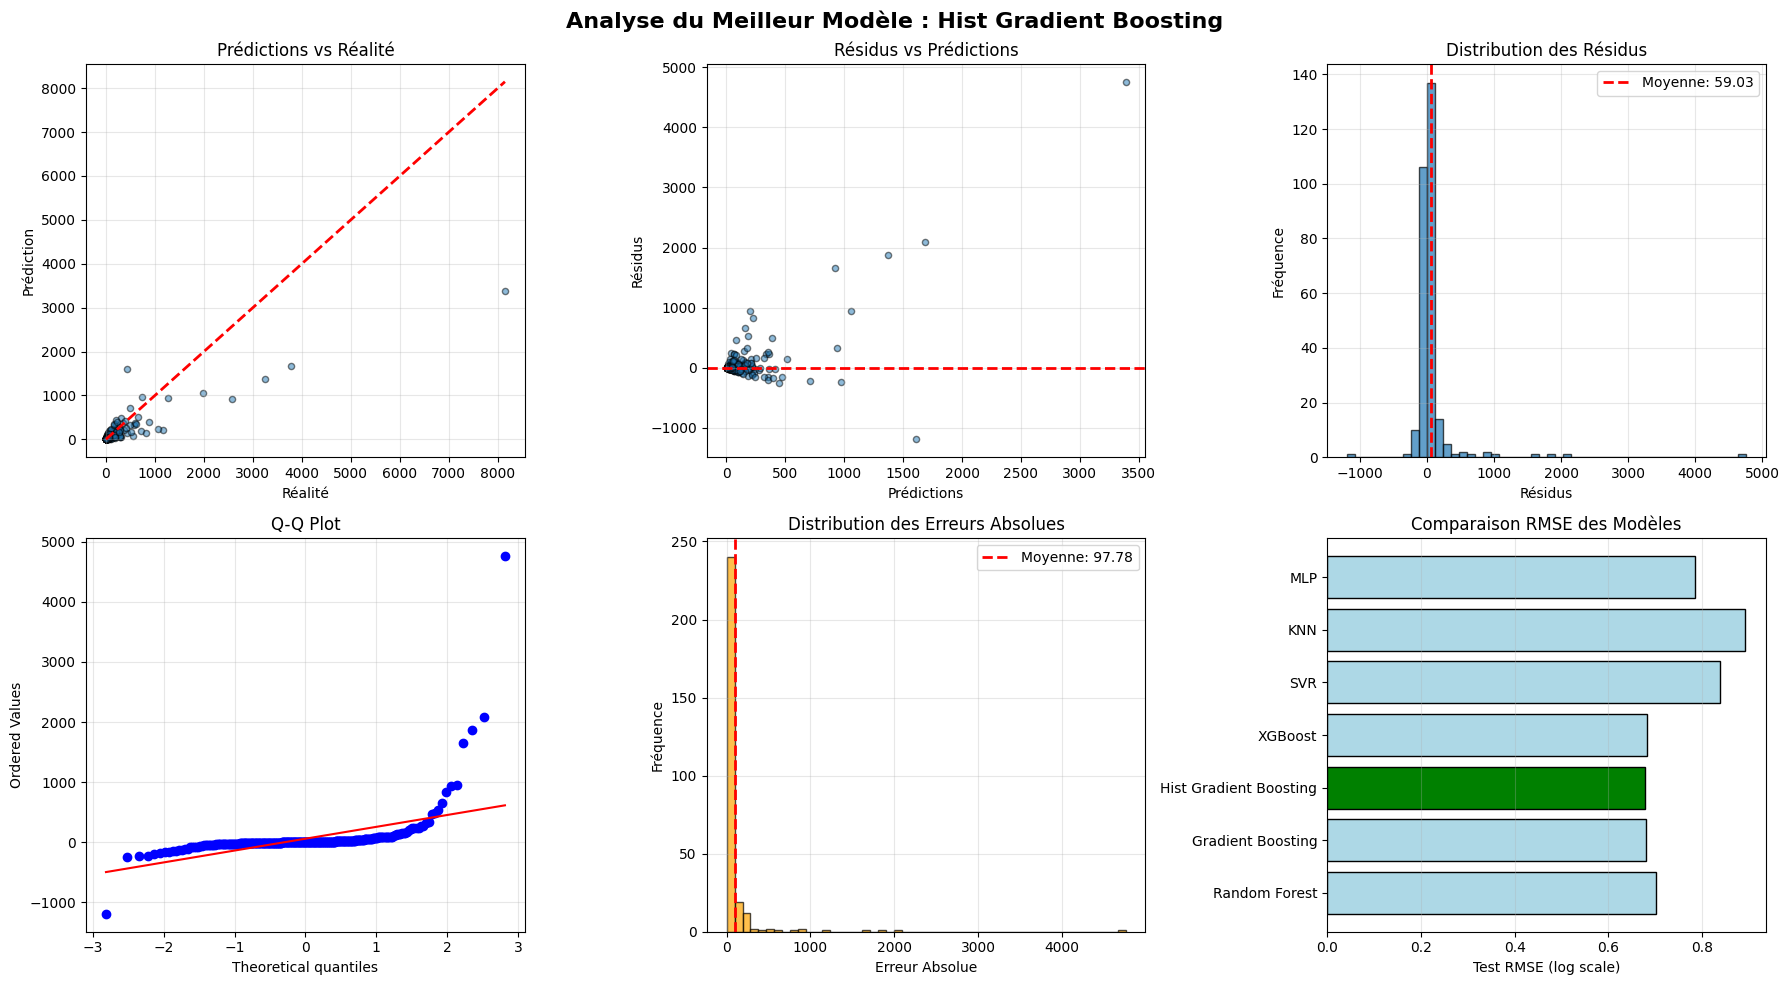

✓ Visualisations générées


In [39]:

# Visualisations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Analyse du Meilleur Modèle : {best_model_name}', fontsize=16, fontweight='bold')

# 1. Prédictions vs Réalité
ax = axes[0, 0]
ax.scatter(y_test_original, y_test_pred_best_original, alpha=0.5, edgecolors='k', s=20)
ax.plot([y_test_original.min(), y_test_original.max()], 
        [y_test_original.min(), y_test_original.max()], 
        'r--', lw=2)
ax.set_xlabel('Réalité')
ax.set_ylabel('Prédiction')
ax.set_title('Prédictions vs Réalité')
ax.grid(True, alpha=0.3)

# 2. Résidus vs Prédictions
ax = axes[0, 1]
ax.scatter(y_test_pred_best_original, residuals, alpha=0.5, edgecolors='k', s=20)
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Prédictions')
ax.set_ylabel('Résidus')
ax.set_title('Résidus vs Prédictions')
ax.grid(True, alpha=0.3)

# 3. Distribution des résidus
ax = axes[0, 2]
ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(residuals.mean(), color='r', linestyle='--', lw=2, label=f'Moyenne: {residuals.mean():.2f}')
ax.set_xlabel('Résidus')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution des Résidus')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Q-Q plot
from scipy import stats
ax = axes[1, 0]
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title('Q-Q Plot')
ax.grid(True, alpha=0.3)

# 5. Erreur Absolue
errors = np.abs(residuals)
ax = axes[1, 1]
ax.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
ax.axvline(errors.mean(), color='r', linestyle='--', lw=2, label=f'Moyenne: {errors.mean():.2f}')
ax.set_xlabel('Erreur Absolue')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution des Erreurs Absolues')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Comparaison des modèles (RMSE)
ax = axes[1, 2]
models_names = results_df['Model'].values
rmse_values = results_df['Test_RMSE'].values
colors = ['green' if name == best_model_name else 'lightblue' for name in models_names]
ax.barh(models_names, rmse_values, color=colors, edgecolor='black')
ax.set_xlabel('Test RMSE (log scale)')
ax.set_title('Comparaison RMSE des Modèles')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"✓ Visualisations générées")



# Section 5 : Analyse d'Importance des Features


In [40]:

# Extrait l'importance des features pour les modèles qui la supportent
def get_feature_names_from_preprocessor(preprocessor, X_train):
    """Obtient les noms des features après transformation par le preprocessor"""
    feature_names = []
    
    # Récupère les transformateurs
    transformers = preprocessor.transformers_
    
    for name, transformer, columns in transformers:
        if name == 'num':
            # Pour le pipeline numérique, on garde les noms
            feature_names.extend(columns)
        elif name == 'cat':
            # Pour le OneHotEncoder, on a besoin des noms des catégories
            if hasattr(transformer, 'named_steps'):
                ohe = transformer.named_steps['ohe']
                if hasattr(ohe, 'get_feature_names_out'):
                    cat_features = ohe.get_feature_names_out(columns)
                    feature_names.extend(cat_features)
    
    return np.array(feature_names)

# Récupère les noms de features
try:
    feature_names = get_feature_names_from_preprocessor(preprocessor, X_train_clean)
    print(f"Nombre total de features après transformation: {len(feature_names)}")
except Exception as e:
    print(f"Attention: Impossible d'extraire les noms de features: {e}")
    feature_names = None

# Affiche l'importance des features si disponible
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    importances = best_model.named_steps['model'].feature_importances_
    
    if feature_names is not None and len(feature_names) == len(importances):
        # Créer un dataframe avec les importances
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print(f"\n{'=' * 80}")
        print(f"TOP 20 Features les plus importantes ({best_model_name})")
        print(f"{'=' * 80}")
        print(feature_importance_df.head(20).to_string(index=False))
        
        # Visualisation
        plt.figure(figsize=(12, 8))
        top_n = 20
        top_features = feature_importance_df.head(top_n)
        plt.barh(range(len(top_features)), top_features['Importance'].values, edgecolor='black')
        plt.yticks(range(len(top_features)), top_features['Feature'].values)
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Features les Plus Importantes ({best_model_name})')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("Impossible d'aligner les noms de features avec les importances")
else:
    print(f"Le modèle {best_model_name} ne supporte pas l'extraction d'importance des features")


Nombre total de features après transformation: 59
Le modèle Hist Gradient Boosting ne supporte pas l'extraction d'importance des features



# Section 6 : Rapport Synthétique


In [ ]:

# Générer un rapport markdown synthétique
report_content = f"""# Rapport de Modélisation - Prédiction d'Émissions CO2 Seattle 2016

## Date du rapport
{datetime.now().strftime("%d/%m/%Y %H:%M:%S")}

## Résumé Exécutif
- **Meilleur Modèle** : {best_model_name}
- **RMSE (log)** : {best_metrics['Test_RMSE']:.4f}
- **RMSE (original)** : {best_metrics['Test_RMSE_Original']:.2f} tonnes CO2
- **MAE (original)** : {best_metrics['Test_MAE_Original']:.2f} tonnes CO2
- **R² Score** : {best_metrics['Test_R2']:.4f}
- **MAPE** : {best_metrics['Test_MAPE']:.4f}
- **Temps d'entraînement** : {best_metrics['Train_Time_s']:.2f}s

## Données
- **Taille de l'ensemble d'entraînement** : {len(X_train_clean)} instances
- **Taille de l'ensemble de test** : {len(X_test_clean)} instances
- **Nombre de features** : {X_train_clean.shape[1]}
- **Target** : TotalGHGEmissions (log-transformée)

## Modèles Testés
Parmi les {len(models)} modèles testés :

"""

# Ajouter les performances de chaque modèle
for idx, row in results_df.iterrows():
    report_content += f"""
### {row['Model']}
- **Test RMSE** : {row['Test_RMSE']:.4f} (original: {row['Test_RMSE_Original']:.2f})
- **Test MAE** : {row['Test_MAE']:.4f} (original: {row['Test_MAE_Original']:.2f})
- **Test R²** : {row['Test_R2']:.4f}
- **Temps d'entraînement** : {row['Train_Time_s']:.2f}s
"""

report_content += f"""

## Analyse des Résidus (Meilleur Modèle)
- **Moyenne des résidus** : {residuals.mean():.2f}
- **Écart-type** : {residuals.std():.2f}
- **Min** : {residuals.min():.2f}
- **Max** : {residuals.max():.2f}
- **Médiane** : {residuals.median():.2f}

## Fichiers Générés
- Comparaison des modèles : `{csv_path.name}`
- Pipeline meilleur modèle : `{best_pipeline_path.name}`
- Métriques : `{metrics_path.name}`
- Tous les modèles : `{all_models_path.name}`

## Prochaines Étapes
1. Fine-tuning des hyperparamètres du meilleur modèle
2. Validation croisée
3. Analyse d'erreurs par type de bâtiment
4. Déploiement du modèle
"""

# Sauvegarder le rapport
report_path = PROJECT_ROOT / "reports" / f"modeling_report_{timestamp}.md"
report_path.parent.mkdir(exist_ok=True, parents=True)
with open(report_path, 'w') as f:
    f.write(report_content)

print(f"✓ Rapport sauvegardé: {report_path}")
print("\n" + "=" * 100)
print(report_content)

### Résumé et fichiers sauvegardés

- Les modèles testés sont : Random Forest, Gradient Boosting, HistGradientBoosting, XGBoost, SVR, KNN et MLP.
- Les métriques calculées sont : **MAE**, **RMSE**, **R2**, **MAPE**.
- Fichiers générés et emplacement :
  - Comparaison complète : `models/model_comparison_<timestamp>.csv` ✅
  - Pipeline du meilleur modèle : `models/best_pipeline_<MODELNAME>_<timestamp>.joblib` ✅
  - Métriques du meilleur modèle : `models/best_metrics_<timestamp>.json` ✅

Prochaine étape : exécuter ce bloc pour valider l'entraînement et vérifier les artefacts dans `models/`.